# 1. Trabalho Prático 2 - Introdução aos Bancos de Dados
## Dados do Cadastro Nacional da Pessoa Jurídica

Antes de qualquer tratamento de entradas, tivemos que elaborar um script em python para a seleção de instâncias relevantes. Esse processo foi extremamente trabalhoso, pois deveríamos evitar qualquer viés que os dados parcialmente selecionados poderiam acarretar. Assim, foram escolhidas 1000 instâncias da planilha sócios (a única que não estava ordenada pelo CNPJ) e achamos os CNPJ's desses 1000 sócios nas tabelas de estabelecimentos, dados do simples e empresas, por meio do script. Essa parte não é exatamente requisitada no enunciado, mas foi crucial para que pudéssemos dar continuidade ao passo a passo fornecido, evitando ambiguidades e inverdades sobre os dados. Como o script foi modificado inúmeras vezes e sua presença direta aqui geraria erros de compilação. Para que não gerasse erros, eu precisaria fornecer todas as tabelas com os dados não utilizados e isso consumiria muito espaço. Também não consegui colocá-las no GitHub pois a plataforma não aceita arquivos com mais de 100Mb, então estabeleci um .gitignore. Assim, disponibilizo aqui o link do repositório público que usamos para armazenas o script em python - lembrando que ele foi adaptado dependendo da tabela que queríamos gerar, um arquivo "detetive" para checar formato das colunas e algumas das tabelas resultantes:
https://github.com/izabelaex/TP2_IBD

# 2. Membros:


*   Izabela Esber Xavier
*   Marcia Bigão Drummond
*  Lara Amélia Maia de Freitas

# 3. Descrição dos dados

  3.1 Iniciando ambiente de processamento dos dados

In [2]:
# importando módulos relevantes para o trabalho
import csv
import pandas as pd
import sqlite3

import requests
from PIL import Image
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import IPython.display as ipd
import urllib.request
import os

In [3]:
# funções auxiliares
def fetch(query, conn, formatted=True):
    # executa a query e pega todas as colunas
    cur = conn.cursor()
    cur.execute(query)
    rs = cur.fetchall()

    # extrai colunas da descrição do cursor
    columns = [desc[0] for desc in cur.description]

    # retorna um dataframe com os nomes das colunas
    return pd.DataFrame(rs, columns=columns) if formatted else rs

def show_tables(conn):
    return [x[0] for x in fetch('SELECT tbl_name FROM sqlite_master WHERE type="table"', conn, False)]

def print_tables(conn):
    tables = fetch('SELECT tbl_name FROM sqlite_master WHERE type="table"', conn, False)
    return pd.DataFrame(tables, columns=['Tabela'])

def shape(table, conn):
    nrows = fetch(f'SELECT COUNT(*) FROM {table}', conn, False)[0][0]
    ncols = fetch(f'SELECT COUNT(*) FROM pragma_table_info("{table}")', conn, False)[0][0]

    return (nrows, ncols)

def desc(table, conn):
    cur = conn.cursor()
    cur.execute(f'PRAGMA table_info("{table}")')
    columns = [row[1] for row in cur.fetchall()]

    return columns

def info(table, conn):
    # table constraints (domain, null, default, pk)
    df1 = fetch(f'PRAGMA table_info("{table}")', conn)
    columns = desc(table, conn)

    # entradas por coluna
    counts = ', '.join([f'COUNT(*) AS "{column}"' for column in columns])
    df2 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df2.columns = ['count']

    # entradas não nulas por coluna
    counts = ', '.join([f'COUNT("{column}") AS "{column}"' for column in columns])
    df3 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df3.columns = ['notnull count']

    # entradas únicas e não nulas por coluna
    counts = ', '.join([f'COUNT(DISTINCT "{column}") AS "{column}"' for column in columns])
    df4 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df4.columns = ['unique count']

    return df1.merge(df2, left_on='name', right_index=True) \
            .merge(df3, left_on='name', right_index=True) \
            .merge(df4, left_on='name', right_index=True)

def hist(data, xlabel='', ylabel='', bins='auto'):
    # converte lista de tuplas em um dataframe
    df = pd.DataFrame(data, columns=['key', 'frequency'])
    # expande os dados baseado nas frequências
    expanded = df.loc[df.index.repeat(df['frequency'])].reset_index(drop=True)

    # plota histograma
    sns.histplot(expanded['key'], bins=bins, kde=False)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.show()

3.1 Carregando dados a serem processados

In [4]:
import csv
import sqlite3
import urllib.request
import os

# URLs de download direto dos arquivos no Google Drive (substitua os IDs abaixo pelos reais)
drive_urls = {
    'empresas.csv': 'https://drive.google.com/uc?export=download&id=1P3FsVBuV1N9lcO47oLnf05y6f_NdbPG_',
    'socios.csv': 'https://drive.google.com/uc?export=download&id=1yBEEQ6on93BvOQreH7zTjXnCpEBAFUHX',
    'estabelecimentos.csv': 'https://drive.google.com/uc?export=download&id=1pzRfXFzfZt6GlI77fS2UzkE2S7yTOUV9',
    'dados_simples.csv': 'https://drive.google.com/uc?export=download&id=1340Sv4BJVYtjpKjSV3OLHlTqCtdPJO9N',
    'pais.csv': 'https://drive.google.com/uc?export=download&id=1YlNUHAq8jBXtq0rgKMNSvijzW9GJa6Md',
    'municipios.csv': 'https://drive.google.com/uc?export=download&id=1z3b6tjE_TgzNLhMHtm3xXLjLoliLGrvH',
    'qualificacao.csv': 'https://drive.google.com/uc?export=download&id=1SEsSqYLqpbgWzvvJbnXsQRDHWxC--pfG',
    'natureza_juridica.csv': 'https://drive.google.com/uc?export=download&id=1_9SMLQA6clOh_3cX94p-YW0fIOMW4pDi',
}

# Faz o download de todos os arquivos CSV no ambiente do Colab
for nome_arquivo, url in drive_urls.items():
    print(f"Baixando {nome_arquivo}...")
    urllib.request.urlretrieve(url, nome_arquivo)

# Lista dos arquivos baixados localmente
sources = list(drive_urls.keys())

# Conecta ao SQLite
conn = sqlite3.connect('cnpj.db')
cur = conn.cursor()

# Define opções do PRAGMA para performance
cur.execute('PRAGMA synchronous = OFF')
cur.execute('PRAGMA journal_mode = MEMORY')

# Define tamanho do batch para inserções
BATCH_SIZE = 1000

# Inicia transação
cur.execute('BEGIN TRANSACTION')

# Processa cada arquivo CSV
for source in sources:
    with open(source, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        header = next(reader)

        table_name = source.split('.')[0].upper()
        print(f"Inserindo dados na tabela SOURCE_{table_name}...")

        # Cria tabela
        columns = [f'"{column}"' for column in header]
        create = f'CREATE TABLE IF NOT EXISTS SOURCE_{table_name} ({", ".join(columns)})'
        cur.execute(create)

        # Prepara inserção
        placeholders = ', '.join(['?'] * len(header))
        insert = f'INSERT INTO SOURCE_{table_name} VALUES ({placeholders})'

        batch = []
        for row in reader:
            batch.append(row)
            if len(batch) == BATCH_SIZE:
                cur.executemany(insert, batch)
                batch = []

        if batch:
            cur.executemany(insert, batch)

        # Atualiza valores vazios para NULL
        update = f'UPDATE SOURCE_{table_name} SET ' + ','.join([f'{column} = NULLIF({column}, "")' for column in columns])
        cur.execute(update)

        # Commit após cada tabela
        conn.commit()

# Restaura PRAGMA
cur.execute('PRAGMA synchronous = FULL')
cur.execute('PRAGMA journal_mode = DELETE')

print("Ingestão completa com sucesso.")


Baixando empresas.csv...
Baixando socios.csv...
Baixando estabelecimentos.csv...
Baixando dados_simples.csv...
Baixando pais.csv...
Baixando municipios.csv...
Baixando qualificacao.csv...
Baixando natureza_juridica.csv...
Inserindo dados na tabela SOURCE_EMPRESAS...
Inserindo dados na tabela SOURCE_SOCIOS...
Inserindo dados na tabela SOURCE_ESTABELECIMENTOS...
Inserindo dados na tabela SOURCE_DADOS_SIMPLES...
Inserindo dados na tabela SOURCE_PAIS...
Inserindo dados na tabela SOURCE_MUNICIPIOS...
Inserindo dados na tabela SOURCE_QUALIFICACAO...
Inserindo dados na tabela SOURCE_NATUREZA_JURIDICA...
Ingestão completa com sucesso.


3.2 Análise exploratória de dados

In [5]:
# mostrar quais tabelas existem inicialmente no banco de dados
tables = show_tables(conn)
print_tables(conn)

,Tabela
0,SOURCE_EMPRESAS
1,SOURCE_SOCIOS
2,SOURCE_ESTABELECIMENTOS
3,SOURCE_DADOS_SIMPLES
4,SOURCE_PAIS
5,SOURCE_MUNICIPIOS
6,SOURCE_QUALIFICACAO
7,SOURCE_NATUREZA_JURIDICA


In [6]:
# mostrar a forma de cada uma das tabelas iniciais do banco
for table in tables:
  print(table + ": ")
  print(shape(table, conn))

SOURCE_EMPRESAS: 
(484, 7)
SOURCE_SOCIOS: 
(1000, 11)
SOURCE_ESTABELECIMENTOS: 
(618, 29)
SOURCE_DADOS_SIMPLES: 
(162, 7)
SOURCE_PAIS: 
(255, 2)
SOURCE_MUNICIPIOS: 
(5572, 2)
SOURCE_QUALIFICACAO: 
(68, 2)
SOURCE_NATUREZA_JURIDICA: 
(90, 2)


In [7]:
# mostrar informações gerais das tabelas
for table in tables:
  print(table + ":")
  ipd.display(info(table, conn))
  print("\n")

SOURCE_EMPRESAS:


,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,EM.CNPJ,,0,None,0,484,484,484
1,1,EM.RAZAO_SOCIAL,,0,None,0,484,484,484
2,2,EM.NATUREZA_JURIDICA,,0,None,0,484,484,9
3,3,EM.QUALIFICACAO_RESP,,0,None,0,484,484,6
4,4,EM.CAPITAL_SOCIAL,,0,None,0,484,484,58
5,5,EM.PORTE,,0,None,0,484,484,3
6,6,EM.ENTE_FEDERATIVO,,0,None,0,484,0,0




SOURCE_SOCIOS:


,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,S.CNPJ,,0,None,0,1000,1000,556
1,1,S.ID,,0,None,0,1000,1000,2
2,2,S.NOME,,0,None,0,1000,998,998
3,3,S.CPF,,0,None,0,1000,1000,998
4,4,S.QUALIFICACAO,,0,None,0,1000,1000,10
5,5,S.ENTRADA_SOCIEDADE,,0,None,0,1000,1000,498
6,6,S.PAIS,,0,None,0,1000,6,5
7,7,S.CPF_REPRESENTANTE,,0,None,0,1000,1000,23
8,8,S.NOME_REPRESENTANTE,,0,None,0,1000,27,22
9,9,S.QUALIFICACAO_REPRESENTANTE,,0,None,0,1000,1000,5




SOURCE_ESTABELECIMENTOS:


,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,ES.CNPJ_BASICO,,0,None,0,618,618,556
1,1,ES.CNPJ_ORDEM,,0,None,0,618,618,10
2,2,ES.CNPJ_DV,,0,None,0,618,618,100
3,3,ES.IDENT_MATRIZ_FILIAL,,0,None,0,618,618,2
4,4,ES.NOME_FANTASIA,,0,None,0,618,264,248
5,5,ES.SITUACAO_CADASTRAL,,0,None,0,618,618,5
6,6,ES.DATA_SITUACAO_CADASTRAL,,0,None,0,618,618,342
7,7,ES.MOTIVO_SITUACAO_CADASTRAL,,0,None,0,618,618,13
8,8,ES.CIDADE_EXTERIOR,,0,None,0,618,0,0
9,9,"ES.PAIS,ES.DATA_INICIO_ATIVIDADE",,0,None,0,618,0,0




SOURCE_DADOS_SIMPLES:


,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,DS.CNPJ,,0,None,0,162,162,162
1,1,DS.OPCAO_SIMPLES,,0,None,0,162,162,2
2,2,DS.DATA_OPCAO_SIMPLES,,0,None,0,162,162,19
3,3,DS.DATA_EXCLUSAO_SIMPLES,,0,None,0,162,162,52
4,4,DS.OPCAO_MEI,,0,None,0,162,162,1
5,5,DS.DATA_OPCAO_MEI,,0,None,0,162,162,2
6,6,DS.DATA_EXCLUSAO_MEI,,0,None,0,162,162,2




SOURCE_PAIS:


,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,P.CODIGO,,0,None,0,255,255,255
1,1,P.NOME,,0,None,0,255,255,254




SOURCE_MUNICIPIOS:


,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,MN.ID,,0,None,0,5572,5572,5572
1,1,MN.NOME,,0,None,0,5572,5572,5291




SOURCE_QUALIFICACAO:


,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,Q.ID,,0,None,0,68,68,68
1,1,Q.NOME,,0,None,0,68,68,68




SOURCE_NATUREZA_JURIDICA:


,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,N.CODIGO,,0,None,0,90,90,90
1,1,N.NOME,,0,None,0,90,90,89


In [8]:
# mostrar algumas linhas aleatorias das tabelas
for table in tables:
  print(table + ":")
  df = fetch(f'SELECT * FROM {table} ORDER BY random() LIMIT 5', conn)
  ipd.display(df)
  print("\n")

SOURCE_EMPRESAS:


,EM.CNPJ,EM.RAZAO_SOCIAL,EM.NATUREZA_JURIDICA,EM.QUALIFICACAO_RESP,EM.CAPITAL_SOCIAL,EM.PORTE,EM.ENTE_FEDERATIVO
0,6900552,DIGESSO-COMERCIO DE GESSO LTDA,2062,49,60000,1,None
1,6875112,ELEICOES 2004 CF - BARRA DE GUABIRABA - PE - C...,3999,16,0,5,None
2,4740169,SCHEME INFORMATICA LTDA.,2240,49,0,1,None
3,6870872,ELEICOES 2004 CF - AGUIAR - PB - COMITE FINANC...,3999,16,0,5,None
4,6884348,ELEICOES 2004 CF - COREMAS - PB - COMITE FINAN...,3999,16,0,5,None




SOURCE_SOCIOS:


,S.CNPJ,S.ID,S.NOME,S.CPF,S.QUALIFICACAO,S.ENTRADA_SOCIEDADE,S.PAIS,S.CPF_REPRESENTANTE,S.NOME_REPRESENTANTE,S.QUALIFICACAO_REPRESENTANTE,S.FAIXA_ETARIA
0,4702590,2,ESTANISLAU MINKIEWICZ FILHO,***899748**,22,20011003,None,***000000**,None,0,7
1,2944029,2,ANTONIO BARBOSA FERREIRA,***011947**,49,20180530,None,***000000**,None,0,7
2,75995431,2,ODAIR FRONZA,***710359**,49,19990803,None,***000000**,None,0,7
3,75956185,2,OLIVINDO DAL MASO,***828459**,22,19741220,None,***000000**,None,0,9
4,38059036,2,ALEXANDRE DE ALMEIDA,***445804**,22,20060822,None,***000000**,None,0,6




SOURCE_ESTABELECIMENTOS:


,ES.CNPJ_BASICO,ES.CNPJ_ORDEM,ES.CNPJ_DV,ES.IDENT_MATRIZ_FILIAL,ES.NOME_FANTASIA,ES.SITUACAO_CADASTRAL,ES.DATA_SITUACAO_CADASTRAL,ES.MOTIVO_SITUACAO_CADASTRAL,ES.CIDADE_EXTERIOR,"ES.PAIS,ES.DATA_INICIO_ATIVIDADE",...,ES.MUNICIPIO,ES.DDD1,ES.TELEFONE1,ES.DDD2,ES.TELEFONE2,ES.DDD_FAX,ES.FAX,ES.EMAIL,ES.SITUACAO_ESPECIAL,ES.DATA_SITUACAO_ESPECIAL
0,1341982,1,48,1,None,8,20170307,1,None,None,...,SP,6875,None,None,None,None,None,None,None,None
1,1339514,5,62,2,HIPER MERCADO GOTARDO,2,20110718,0,None,None,...,MT,9937,65,33113900,None,None,None,None,hiper@gotardo.com.br,None
2,38684767,1,50,1,None,2,20041016,0,None,None,...,MG,5425,31,31158888,None,None,31,31158888,ATENDIMENTO@INVESTIMOVEIS.COM.BR,None
3,4712420,2,32,2,None,8,20071022,1,None,None,...,PR,7691,44,2235736,None,None,44,2235736,None,None
4,6899704,1,24,1,None,8,20041231,1,None,None,...,PB,2059,None,None,None,None,None,None,None,None




SOURCE_DADOS_SIMPLES:


,DS.CNPJ,DS.OPCAO_SIMPLES,DS.DATA_OPCAO_SIMPLES,DS.DATA_EXCLUSAO_SIMPLES,DS.OPCAO_MEI,DS.DATA_OPCAO_MEI,DS.DATA_EXCLUSAO_MEI
0,6044728,N,20170101,20171231,N,0,0
1,6900576,S,20250101,0,N,0,0
2,6893920,N,20070701,20101231,N,0,0
3,76083989,N,20070701,20150318,N,0,0
4,6881011,N,20070701,20150209,N,0,0




SOURCE_PAIS:


,P.CODIGO,P.NOME
0,542,NOVA CALEDONIA
1,97,BOLIVIA
2,576,PAQUISTAO
3,831,UCRANIA
4,847,"UZBEQUISTAO, REPUBLICA DO"




SOURCE_MUNICIPIOS:


,MN.ID,MN.NOME
0,8477,SULINA
1,3757,NOVA ITARANA
2,735,BENEDITO LEITE
3,4119,BELA VISTA DE MINAS
4,850,ESPERANCA NOVA




SOURCE_QUALIFICACAO:


,Q.ID,Q.NOME
0,72,Diretor Residente ou Domiciliado no Exterior
1,66,Titular Pessoa Física Residente ou Domiciliado...
2,31,Sócio Ostensivo
3,74,Sócio-Administrador Residente ou Domiciliado n...
4,0,Não informada




SOURCE_NATUREZA_JURIDICA:


,N.CODIGO,N.NOME
0,2321,Sociedade Unipessoal de Advocacia
1,2054,Sociedade Anônima Fechada
2,3212,Fundação ou Associação Domiciliada no Exterior
3,0,Natureza Jurídica não informada
4,5029,Representação Diplomática Estrangeira


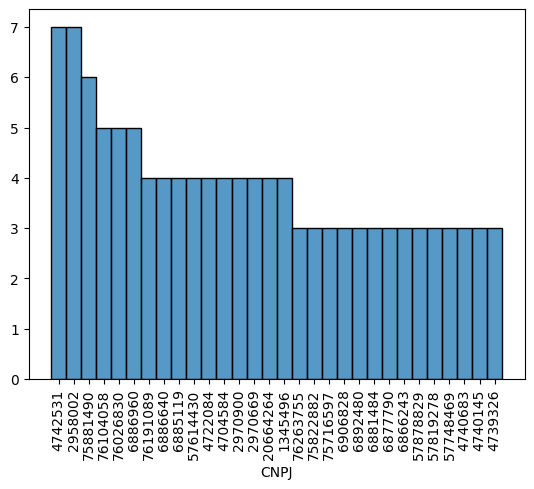

In [9]:
# realizando análises separadas das variáveis mais importantes

# verificando a distribuição de sócios por CNPJ
distro = fetch('SELECT "S.CNPJ" , COUNT(*) AS Frequency FROM SOURCE_SOCIOS GROUP BY "S.CNPJ" HAVING Frequency > 1 ORDER BY Frequency DESC LIMIT 30', conn, False)
hist(distro, xlabel='CNPJ')

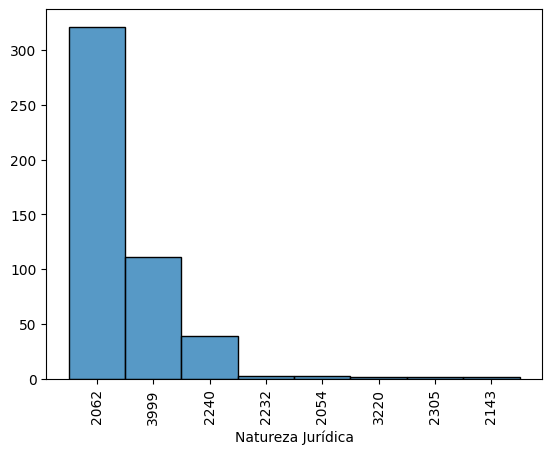

In [10]:
# empresas por natureza jurídica
distro = fetch('SELECT "EM.NATUREZA_JURIDICA" , COUNT(*) AS Frequency FROM SOURCE_EMPRESAS GROUP BY "EM.NATUREZA_JURIDICA" HAVING Frequency > 1 ORDER BY Frequency DESC LIMIT 30', conn, False)
hist(distro, xlabel='Natureza Jurídica')

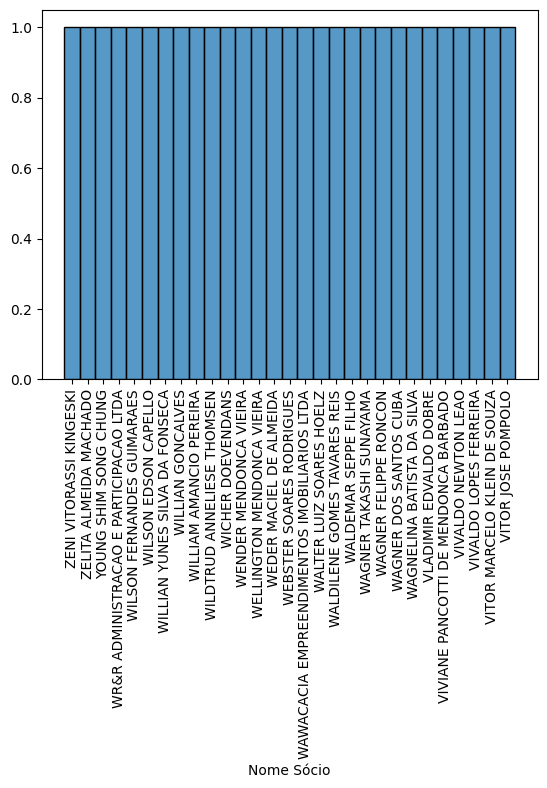

In [11]:
# CNPJ por sócio
distro = fetch('SELECT "S.NOME", COUNT(*) AS NumEmpresas FROM SOURCE_SOCIOS GROUP BY "S.NOME" ORDER BY NumEmpresas DESC LIMIT 30', conn, False)
hist(distro, xlabel='Nome Sócio')

3.3 Normalização

In [12]:
# adicionando identificadores às tabelas originais

def coluna_existe(conn, tabela, coluna):
    cur = conn.cursor()
    cur.execute(f'PRAGMA table_info({tabela})')
    colunas = [row[1] for row in cur.fetchall()]
    return coluna in colunas

new_ids = {
    'EMPRESAS' : 'EM_ID',
    'SOCIOS' : 'S_ID',
    'ESTABELECIMENTOS' : 'ES_ID',
    'DADOS_SIMPLES' : 'DS_ID',
    }


for table in tables:
    id_col = new_ids.get(table)
    if id_col and not coluna_existe(conn, table, id_col):
        ddl = [
            f'ALTER TABLE {table} ADD COLUMN {id_col} INTEGER;',
            f'UPDATE {table} SET {id_col} = rowid;'
        ]
        for q in ddl:
            cur.execute(q)

        #commitar mudancas
        conn.commit()

In [13]:
# criando esquema normalizado

ddl = [
    '''
    CREATE TABLE IF NOT EXISTS EMPRESAS (
      EM_ID INTEGER PRIMARY KEY AUTOINCREMENT,
      EM_CNPJ TEXT NOT NULL,
      EM_RAZAO_SOCIAL TEXT NOT NULL,
      EM_QUALIFICACAO_RESP INTEGER NOT NULL,
      EM_CAPITAL_SOCIAL INTEGER NOT NULL,
      EM_PORTE FLOAT,
      EM_NATUREZA_JURIDICA INTEGER NOT NULL,

      FOREIGN KEY (EM_NATUREZA_JURIDICA) REFERENCES NATUREZA_JURIDICA(N_CODIGO),
      FOREIGN KEY (EM_QUALIFICACAO_RESP) REFERENCES QUALIFICACAO(Q_ID)
    )
    ''',
    '''
    CREATE TABLE IF NOT EXISTS QUALIFICACAO (
      Q_ID INTEGER PRIMARY KEY,
      Q_NOME TEXT NOT NULL
    )
    ''',
    '''
    CREATE TABLE IF NOT EXISTS NATUREZA_JURIDICA (
      N_CODIGO INTEGER PRIMARY KEY,
      N_NOME TEXT NOT NULL
    )
    ''',
    '''
    CREATE TABLE IF NOT EXISTS EMPRESA_NATUREZA_ENTE (
      EMPRESA_ID INTEGER PRIMARY KEY,
      NATUREZA_ID INTEGER,
      ENTE INTEGER,

      FOREIGN KEY (EMPRESA_ID) REFERENCES EMPRESAS(EM_ID),
      FOREIGN KEY (NATUREZA_ID) REFERENCES NATUREZA_JURIDICA(N_CODIGO)
    )
    ''',
    '''
    CREATE TABLE IF NOT EXISTS SOCIOS (
      S_ID INTEGER PRIMARY KEY AUTOINCREMENT,
      S_TIPO INTEGER NOT NULL,
      S_NOME TEXT NOT NULL,
      S_CPF TEXT NOT NULL,
      S_QUALIFICACAO INTEGER NOT NULL,
      S_ENTRADA_SOCIEDADE DATE NOT NULL,
      S_PAIS INTEGER NOT NULL,
      S_REPRESENTANTE INTEGER,
      S_FAIXA_ETARIA INTEGER NOT NULL,

      FOREIGN KEY (S_REPRESENTANTE) REFERENCES REPRESENTANTES(R_ID),
      FOREIGN KEY (S_QUALIFICACAO) REFERENCES QUALIFICACAO(Q_ID),
      FOREIGN KEY (S_PAIS) REFERENCES PAIS(P_ID)
    )
    ''',
    '''
    CREATE TABLE IF NOT EXISTS REPRESENTANTES (
      R_ID INTEGER PRIMARY KEY AUTOINCREMENT,
      R_CPF TEXT NOT NULL,
      R_NOME TEXT NOT NULL,
      R_QUALIFICACAO INTEGER NOT NULL,

      FOREIGN KEY (R_QUALIFICACAO) REFERENCES QUALIFICACAO(Q_ID)
    )
    ''',
    '''
    CREATE TABLE IF NOT EXISTS ESTABELECIMENTO (
      ES_ID INTEGER PRIMARY KEY AUTOINCREMENT,
      ES_CNPJ_BASICO INTEGER NOT NULL,
      ES_CNPJ_ORDEM TEXT NOT NULL,
      ES_CNPJ_BV TEXT NOT NULL,
      ES_IDENT_MATRIZ_FILIAL INTEGER NOT NULL,
      ES_NOME_FANTASIA TEXT,
      ES_SITUACAO_CADASTRAL INTEGER NOT NULL,
      ES_DATA_SITUACAO_CADASTRAL DATE NOT NULL,
      ES_MOTIVO_SITUACAO_CADASTRAL INTEGER NOT NULL,
      ES_CIDADE_EXTERIOR TEXT,
      ES_PAIS INTEGER NOT NULL,
      ES_DATA_INICIO_ATIVIDADE DATE NOT NULL,
      ES_CNAE_PRINCIPAL TEXT NOT NULL,
      ES_CNAE_SECUNDARIA TEXT,
      ES_TIPO_LOGRADOURO TEXT,
      ES_LOGRADOURO TEXT NOT NULL,
      ES_NUMERO INTEGER NOT NULL,
      ES_COMPLEMENTO TEXT,
      ES_BAIRRO TEXT,
      ES_CEP TEXT,
      ES_UF TEXT NOT NULL,
      ES_MUNICIPIO INTEGER NOT NULL,
      ES_CORREIO_ELETRONICO TEXT,
      ES_SITU_ESPECIAL TEXT,
      ES_DATA_SITU_ESPECIAL DATE,

      FOREIGN KEY (ES_PAIS) REFERENCES PAIS(P_ID),
      FOREIGN KEY (ES_MUNICIPIO) REFERENCES MUNICIPIOS(MN_ID),
      FOREIGN KEY (ES_CNPJ_BASICO) REFERENCES EMPRESAS(EM_ID)
    )
    ''',
    '''
    CREATE TABLE IF NOT EXISTS TELEFONES (
      ID_ESTABELECIMENTO INTEGER,
      T_DDD INTEGER,
      T_TELEFONE TEXT,

      PRIMARY KEY(T_DDD, T_TELEFONE)
    )
    ''',
    '''
    CREATE TABLE IF NOT EXISTS PAIS (
      P_ID INTEGER PRIMARY KEY,
      P_NOME TEXT NOT NULL
    )
    ''',
    '''
    CREATE TABLE IF NOT EXISTS SIMPLES (
      SI_ID INTEGER PRIMARY KEY AUTOINCREMENT,
      SI_DATA_OPCAO_SIMPLES DATE,
      SI_DATA_EXCLUSAO_SIMPLES DATE
    )
    ''',
    '''
    CREATE TABLE IF NOT EXISTS MEI (
      M_ID INTEGER PRIMARY KEY AUTOINCREMENT,
      M_DATA_OPCAO_MEI DATE,
      M_DATA_EXCLUSAO_MEI DATE
    )
    ''',
    '''
    CREATE TABLE IF NOT EXISTS DADOS_SIMPLES (
      DS_ID INTEGER PRIMARY KEY AUTOINCREMENT,
      DS_EMPRESA_ID INTEGER NOT NULL,
      DS_SIMPLES INTEGER NOT NULL,
      DS_MEI INTEGER,

      FOREIGN KEY (DS_SIMPLES) REFERENCES SIMPLES(SI_ID),
      FOREIGN KEY (DS_MEI) REFERENCES MEI(M_ID),
      FOREIGN KEY (DS_EMPRESA_ID) REFERENCES EMPRESAS(E_ID)
    )
    ''',
    '''
    CREATE TABLE IF NOT EXISTS EMPRESAS_SOCIOS (
      EMPRESA_ID INTEGER,
      SOCIOS_ID INTEGER,

      PRIMARY KEY(EMPRESA_ID, SOCIOS_ID),
      FOREIGN KEY (EMPRESA_ID) REFERENCES EMPRESAS(E_ID),
      FOREIGN KEY (SOCIOS_ID) REFERENCES SOCIOS(S_ID)
    )
    ''',
    '''
    CREATE TABLE IF NOT EXISTS MUNICIPIOS (
      MN_ID INTEGER PRIMARY KEY,
      MN_NOME TEXT NOT NULL
    )
    '''
]

for q in ddl:
    cur.execute(q)

# commitar mudanças
conn.commit()

print_tables(conn)

,Tabela
0,SOURCE_EMPRESAS
1,SOURCE_SOCIOS
2,SOURCE_ESTABELECIMENTOS
3,SOURCE_DADOS_SIMPLES
4,SOURCE_PAIS
5,SOURCE_MUNICIPIOS
6,SOURCE_QUALIFICACAO
7,SOURCE_NATUREZA_JURIDICA
8,EMPRESAS
9,sqlite_sequence


In [14]:
# migração natureza jurídica

cur.execute('DELETE FROM NATUREZA_JURIDICA')
cur.execute('''
INSERT INTO NATUREZA_JURIDICA (
  N_CODIGO,
  N_NOME
)
SELECT
  "N.CODIGO",
  "N.NOME"
FROM SOURCE_NATUREZA_JURIDICA
''')

conn.commit()
ipd.display(info('NATUREZA_JURIDICA', conn))

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,N_CODIGO,INTEGER,0,None,1,90,90,90
1,1,N_NOME,TEXT,1,None,0,90,90,89


In [15]:
# migracao qualificacoes

cur.execute('DELETE FROM QUALIFICACAO')
cur.execute('''
INSERT INTO QUALIFICACAO (
  Q_ID,
  Q_NOME
)
SELECT
  "Q.ID",
  "Q.NOME"
FROM SOURCE_QUALIFICACAO
''')

conn.commit()
ipd.display(info('QUALIFICACAO', conn))

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,Q_ID,INTEGER,0,None,1,68,68,68
1,1,Q_NOME,TEXT,1,None,0,68,68,68


In [16]:
# migracao países

cur.execute('DELETE FROM PAIS')
cur.execute('''
INSERT INTO PAIS (
  P_ID,
  P_NOME
)
SELECT
  "P.CODIGO",
  "P.NOME"
FROM SOURCE_PAIS
''')

conn.commit()
ipd.display(info('PAIS', conn))

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,P_ID,INTEGER,0,None,1,255,255,255
1,1,P_NOME,TEXT,1,None,0,255,255,254


In [17]:
# migracao municípios

cur.execute('DELETE FROM MUNICIPIOS')
cur.execute('''
INSERT INTO MUNICIPIOS (
  MN_ID,
  MN_NOME
)
SELECT
  "MN.ID",
  "MN.NOME"
FROM SOURCE_MUNICIPIOS
''')

conn.commit()
ipd.display(info('MUNICIPIOS', conn))

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,MN_ID,INTEGER,0,None,1,5572,5572,5572
1,1,MN_NOME,TEXT,1,None,0,5572,5572,5291


In [18]:
# migração das empresas

cur.execute('DELETE FROM EMPRESAS')
cur.execute('''
INSERT INTO EMPRESAS (
  EM_CNPJ,
  EM_RAZAO_SOCIAL,
  EM_QUALIFICACAO_RESP,
  EM_CAPITAL_SOCIAL,
  EM_PORTE,
  EM_NATUREZA_JURIDICA
)
SELECT
  "EM.CNPJ",
  "EM.RAZAO_SOCIAL",
  "EM.QUALIFICACAO_RESP",
  "EM.CAPITAL_SOCIAL",
  "EM.PORTE",
  "EM.NATUREZA_JURIDICA"
FROM SOURCE_EMPRESAS
''')

conn.commit()

ipd.display(info('EMPRESAS', conn))

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,EM_ID,INTEGER,0,None,1,484,484,484
1,1,EM_CNPJ,TEXT,1,None,0,484,484,484
2,2,EM_RAZAO_SOCIAL,TEXT,1,None,0,484,484,484
3,3,EM_QUALIFICACAO_RESP,INTEGER,1,None,0,484,484,6
4,4,EM_CAPITAL_SOCIAL,INTEGER,1,None,0,484,484,58
5,5,EM_PORTE,FLOAT,0,None,0,484,484,3
6,6,EM_NATUREZA_JURIDICA,INTEGER,1,None,0,484,484,9


In [19]:
# migração representantes

cur.execute('DELETE FROM REPRESENTANTES')
cur.execute('''
INSERT INTO REPRESENTANTES (
  R_CPF,
  R_NOME,
  R_QUALIFICACAO
)
SELECT DISTINCT
  "S.CPF_REPRESENTANTE",
  "S.NOME_REPRESENTANTE",
  "S.QUALIFICACAO_REPRESENTANTE"
FROM SOURCE_SOCIOS
WHERE
  "S.CPF_REPRESENTANTE" IS NOT NULL AND
  "S.NOME_REPRESENTANTE" IS NOT NULL AND
  "S.QUALIFICACAO_REPRESENTANTE" IS NOT NULL
''')

conn.commit()
ipd.display(info('REPRESENTANTES', conn))

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,R_ID,INTEGER,0,None,1,23,23,23
1,1,R_CPF,TEXT,1,None,0,23,23,22
2,2,R_NOME,TEXT,1,None,0,23,23,22
3,3,R_QUALIFICACAO,INTEGER,1,None,0,23,23,4


In [20]:
# migração sócios

cur.execute('DELETE FROM SOCIOS')
cur.execute('''
INSERT INTO SOCIOS (
  S_TIPO,
  S_NOME,
  S_CPF,
  S_QUALIFICACAO,
  S_ENTRADA_SOCIEDADE,
  S_PAIS,
  S_REPRESENTANTE,
  S_FAIXA_ETARIA
)
SELECT DISTINCT
  "S.ID",
  "S.NOME",
  "S.CPF",
  "S.QUALIFICACAO",
  "S.ENTRADA_SOCIEDADE",
  COALESCE("S.PAIS", 0),
  "R_ID",
  "S.FAIXA_ETARIA"
FROM SOURCE_SOCIOS
LEFT OUTER JOIN REPRESENTANTES ON R_CPF == "S.CPF_REPRESENTANTE"
WHERE "S.NOME" IS NOT NULL
''')

conn.commit()
ipd.display(info('SOCIOS', conn))

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,S_ID,INTEGER,0,None,1,1000,1000,1000
1,1,S_TIPO,INTEGER,1,None,0,1000,1000,2
2,2,S_NOME,TEXT,1,None,0,1000,1000,998
3,3,S_CPF,TEXT,1,None,0,1000,1000,997
4,4,S_QUALIFICACAO,INTEGER,1,None,0,1000,1000,10
5,5,S_ENTRADA_SOCIEDADE,DATE,1,None,0,1000,1000,498
6,6,S_PAIS,INTEGER,1,None,0,1000,1000,6
7,7,S_REPRESENTANTE,INTEGER,0,None,0,1000,29,23
8,8,S_FAIXA_ETARIA,INTEGER,1,None,0,1000,1000,9


In [21]:
# migração sócios-empresas

cur.execute('DELETE FROM EMPRESAS_SOCIOS')
cur.execute('''
INSERT INTO EMPRESAS_SOCIOS (
  EMPRESA_ID,
  SOCIOS_ID
)
SELECT DISTINCT
  E.EM_ID,
  S.S_ID
FROM SOURCE_EMPRESAS
JOIN SOURCE_SOCIOS ON "EM.CNPJ" = "S.CNPJ"
JOIN EMPRESAS E ON EM_CNPJ = "EM.CNPJ"
JOIN SOCIOS S ON S_CPF = "S.CPF"
WHERE "S.NOME" IS NOT NULL;
''')

conn.commit()
ipd.display(info('EMPRESAS_SOCIOS', conn))

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,EMPRESA_ID,INTEGER,0,None,1,859,859,483
1,1,SOCIOS_ID,INTEGER,0,None,2,859,859,857


In [22]:
# migração empresa_natureza_ente


cur.execute('DELETE FROM EMPRESA_NATUREZA_ENTE')
cur.execute('''
INSERT INTO EMPRESA_NATUREZA_ENTE (
  EMPRESA_ID,
  NATUREZA_ID,
  ENTE
)
SELECT DISTINCT
  EM_ID,
  "EM.NATUREZA_JURIDICA",
  "EM.ENTE_FEDERATIVO"
FROM SOURCE_EMPRESAS
JOIN EMPRESAS ON EM_CNPJ = "EM.CNPJ"
WHERE "EM.ENTE_FEDERATIVO" IS NOT NULL
''')

conn.commit()
ipd.display(info('EMPRESA_NATUREZA_ENTE', conn))

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,EMPRESA_ID,INTEGER,0,None,1,0,0,0
1,1,NATUREZA_ID,INTEGER,0,None,0,0,0,0
2,2,ENTE,INTEGER,0,None,0,0,0,0


In [23]:
# migração mei

cur.execute('DELETE FROM MEI')
cur.execute('''
INSERT INTO MEI (
  M_DATA_OPCAO_MEI,
  M_DATA_EXCLUSAO_MEI
)
SELECT DISTINCT
  "DS.DATA_OPCAO_MEI",
  "DS.DATA_EXCLUSAO_MEI"
FROM SOURCE_DADOS_SIMPLES
WHERE "DS.OPCAO_MEI" = 'S'
''')

conn.commit()
ipd.display(info('MEI', conn))

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,M_ID,INTEGER,0,None,1,0,0,0
1,1,M_DATA_OPCAO_MEI,DATE,0,None,0,0,0,0
2,2,M_DATA_EXCLUSAO_MEI,DATE,0,None,0,0,0,0


In [24]:
# migração simples

cur.execute('DELETE FROM SIMPLES')
cur.execute('''
INSERT INTO SIMPLES (
  SI_DATA_OPCAO_SIMPLES,
  SI_DATA_EXCLUSAO_SIMPLES
)
SELECT DISTINCT
  "DS.DATA_OPCAO_SIMPLES",
  "DS.DATA_EXCLUSAO_SIMPLES"
FROM SOURCE_DADOS_SIMPLES
WHERE "DS.OPCAO_SIMPLES" = 'S'
''')

conn.commit()
ipd.display(info('SIMPLES', conn))


,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,SI_ID,INTEGER,0,None,1,14,14,14
1,1,SI_DATA_OPCAO_SIMPLES,DATE,0,None,0,14,14,14
2,2,SI_DATA_EXCLUSAO_SIMPLES,DATE,0,None,0,14,14,1


In [25]:
# migração dados_simples

cur.execute('DELETE FROM DADOS_SIMPLES')
cur.execute('''
INSERT INTO DADOS_SIMPLES (
  DS_EMPRESA_ID,
  DS_SIMPLES,
  DS_MEI
)
SELECT DISTINCT
  E.EM_ID,
  S.SI_ID,
  M.M_ID
FROM SOURCE_DADOS_SIMPLES AS SDS
JOIN EMPRESAS AS E ON E.EM_CNPJ = SDS."DS.CNPJ"
LEFT JOIN SIMPLES AS S ON
    S.SI_DATA_OPCAO_SIMPLES = SDS."DS.DATA_OPCAO_SIMPLES" AND
    S.SI_DATA_EXCLUSAO_SIMPLES = SDS."DS.DATA_EXCLUSAO_SIMPLES"
LEFT JOIN MEI AS M ON
    M.M_DATA_OPCAO_MEI = SDS."DS.DATA_OPCAO_MEI" AND
    M.M_DATA_EXCLUSAO_MEI = SDS."DS.DATA_EXCLUSAO_MEI"
WHERE S.SI_ID IS NOT NULL
''')

conn.commit()
ipd.display(info('DADOS_SIMPLES', conn))

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,DS_ID,INTEGER,0,None,1,62,62,62
1,1,DS_EMPRESA_ID,INTEGER,1,None,0,62,62,62
2,2,DS_SIMPLES,INTEGER,1,None,0,62,62,14
3,3,DS_MEI,INTEGER,0,None,0,62,0,0


In [26]:
# migração estabelecimento

cur.execute('DELETE FROM ESTABELECIMENTO')
cur.execute('''
INSERT INTO ESTABELECIMENTO (
  ES_CNPJ_BASICO,
  ES_CNPJ_ORDEM,
  ES_CNPJ_BV,
  ES_IDENT_MATRIZ_FILIAL,
  ES_NOME_FANTASIA,
  ES_SITUACAO_CADASTRAL,
  ES_DATA_SITUACAO_CADASTRAL,
  ES_MOTIVO_SITUACAO_CADASTRAL,
  ES_CIDADE_EXTERIOR,
  ES_PAIS,
  ES_DATA_INICIO_ATIVIDADE,
  ES_CNAE_PRINCIPAL,
  ES_CNAE_SECUNDARIA,
  ES_TIPO_LOGRADOURO,
  ES_LOGRADOURO,
  ES_NUMERO,
  ES_COMPLEMENTO,
  ES_BAIRRO,
  ES_CEP,
  ES_UF,
  ES_MUNICIPIO,
  ES_CORREIO_ELETRONICO,
  ES_SITU_ESPECIAL,
  ES_DATA_SITU_ESPECIAL
)
SELECT DISTINCT
  EM_ID,
  "ES.CNPJ_ORDEM",
  "ES.CNPJ_DV",
  "ES.IDENT_MATRIZ_FILIAL",
  "ES.NOME_FANTASIA",
  "ES.SITUACAO_CADASTRAL",
  "ES.DATA_SITUACAO_CADASTRAL",
  "ES.MOTIVO_SITUACAO_CADASTRAL",
  "ES.CIDADE_EXTERIOR",
  "ES.PAIS",
  "ES.DATA_INICIO_ATIVIDADE",
  "ES.CNAE_PRINCIPAL",
  "ES.CNAE_SECUNDARIA",
  "ES.TIPO_LOGRADOURO",
  "ES.LOGRADOURO",
  "ES.NUMERO",
  "ES.COMPLEMENTO",
  "ES.BAIRRO",
  "ES.CEP",
  "ES.UF",
  "ES.MUNICIPIO",
  "ES.EMAIL",
  "ES.SITUACAO_ESPECIAL",
  "ES.DATA_SITUACAO_ESPECIAL"
FROM SOURCE_ESTABELECIMENTOS
JOIN EMPRESAS ON EM_CNPJ = "ES.CNPJ_BASICO"
WHERE "ES.LOGRADOURO" IS NOT NULL AND
      "ES.NUMERO" IS NOT NULL AND
      "ES.UF" IS NOT NULL AND
      "ES.MUNICIPIO" IS NOT NULL
''')

conn.commit()
ipd.display(info('ESTABELECIMENTO', conn))


,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,ES_ID,INTEGER,0,None,1,506,506,506
1,1,ES_CNPJ_BASICO,INTEGER,1,None,0,506,506,463
2,2,ES_CNPJ_ORDEM,TEXT,1,None,0,506,506,9
3,3,ES_CNPJ_BV,TEXT,1,None,0,506,506,100
4,4,ES_IDENT_MATRIZ_FILIAL,INTEGER,1,None,0,506,506,2
5,5,ES_NOME_FANTASIA,TEXT,0,None,0,506,227,213
6,6,ES_SITUACAO_CADASTRAL,INTEGER,1,None,0,506,506,5
7,7,ES_DATA_SITUACAO_CADASTRAL,DATE,1,None,0,506,506,281
8,8,ES_MOTIVO_SITUACAO_CADASTRAL,INTEGER,1,None,0,506,506,12
9,9,ES_CIDADE_EXTERIOR,TEXT,0,None,0,506,0,0


In [27]:
# migração telefones

cur.execute('DELETE FROM TELEFONES')
cur.execute('''
INSERT OR IGNORE INTO TELEFONES (
  ID_ESTABELECIMENTO,
  T_DDD,
  T_TELEFONE
)
SELECT DISTINCT
    ES_ID,
    "ES.DDD1",
    "ES.TELEFONE1"
FROM SOURCE_ESTABELECIMENTOS
JOIN EMPRESAS ON EM_CNPJ = "ES.CNPJ_BASICO"
JOIN ESTABELECIMENTO ON ES_CNPJ_BASICO = EM_ID
WHERE "ES.TELEFONE1" IS NOT NULL
UNION
SELECT DISTINCT
    ES_ID,
    "ES.DDD2",
    "ES.TELEFONE2"
FROM SOURCE_ESTABELECIMENTOS
JOIN EMPRESAS ON EM_CNPJ = "ES.CNPJ_BASICO"
JOIN ESTABELECIMENTO ON ES_CNPJ_BASICO = EM_ID
WHERE "ES.TELEFONE2" IS NOT NULL
''')

conn.commit()
ipd.display(info('TELEFONES', conn))


,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,ID_ESTABELECIMENTO,INTEGER,0,None,0,193,193,154
1,1,T_DDD,INTEGER,0,None,1,193,193,190
2,2,T_TELEFONE,TEXT,0,None,2,193,193,49


In [28]:
ddl = [
    'DROP TABLE SOURCE_EMPRESAS;',
    'DROP TABLE SOURCE_SOCIOS;',
    'DROP TABLE SOURCE_ESTABELECIMENTOS;',
    'DROP TABLE SOURCE_DADOS_SIMPLES;',
    'DROP TABLE SOURCE_PAIS;',
    'DROP TABLE SOURCE_MUNICIPIOS;',
    'DROP TABLE SOURCE_QUALIFICACAO;',
    'DROP TABLE SOURCE_NATUREZA_JURIDICA;'
]

for q in ddl:
    cur.execute(q)

# commitar mudanças
conn.commit()

print_tables(conn)

,Tabela
0,EMPRESAS
1,sqlite_sequence
2,QUALIFICACAO
3,NATUREZA_JURIDICA
4,EMPRESA_NATUREZA_ENTE
5,SOCIOS
6,REPRESENTANTES
7,ESTABELECIMENTO
8,TELEFONES
9,PAIS


# 4. Diagrama ER

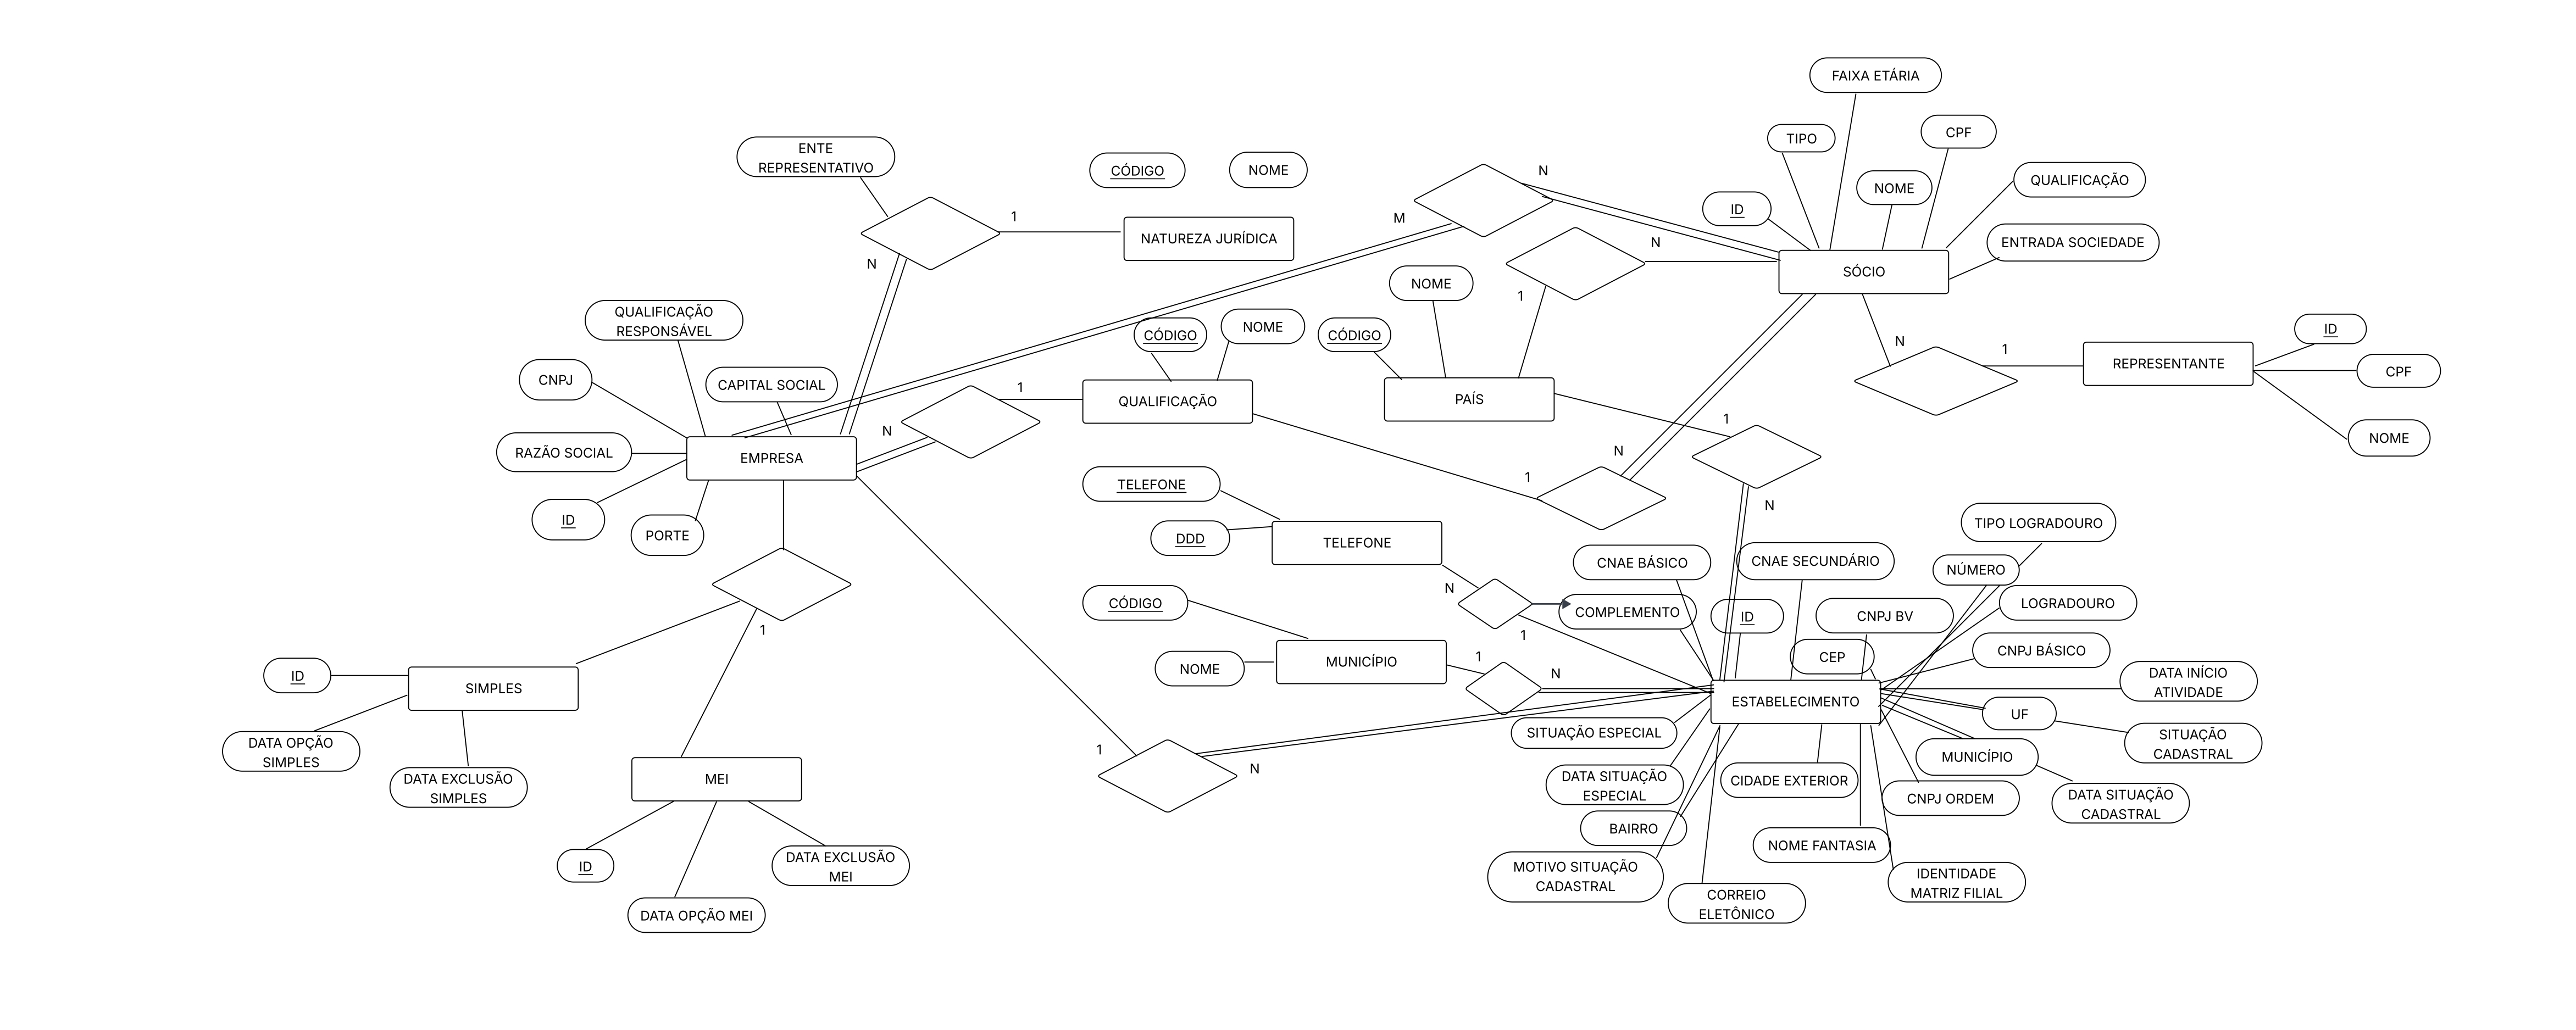

In [29]:
import requests
from io import BytesIO
from IPython.display import Image, display

url = 'https://drive.google.com/uc?export=download&id=1fC5GclDG5sKf8kIV1bzQM36aUz6D78MS'

response = requests.get(url)
img = BytesIO(response.content)
display(Image(data=img.read(), width=2000))


# 5. Diagrama relacional

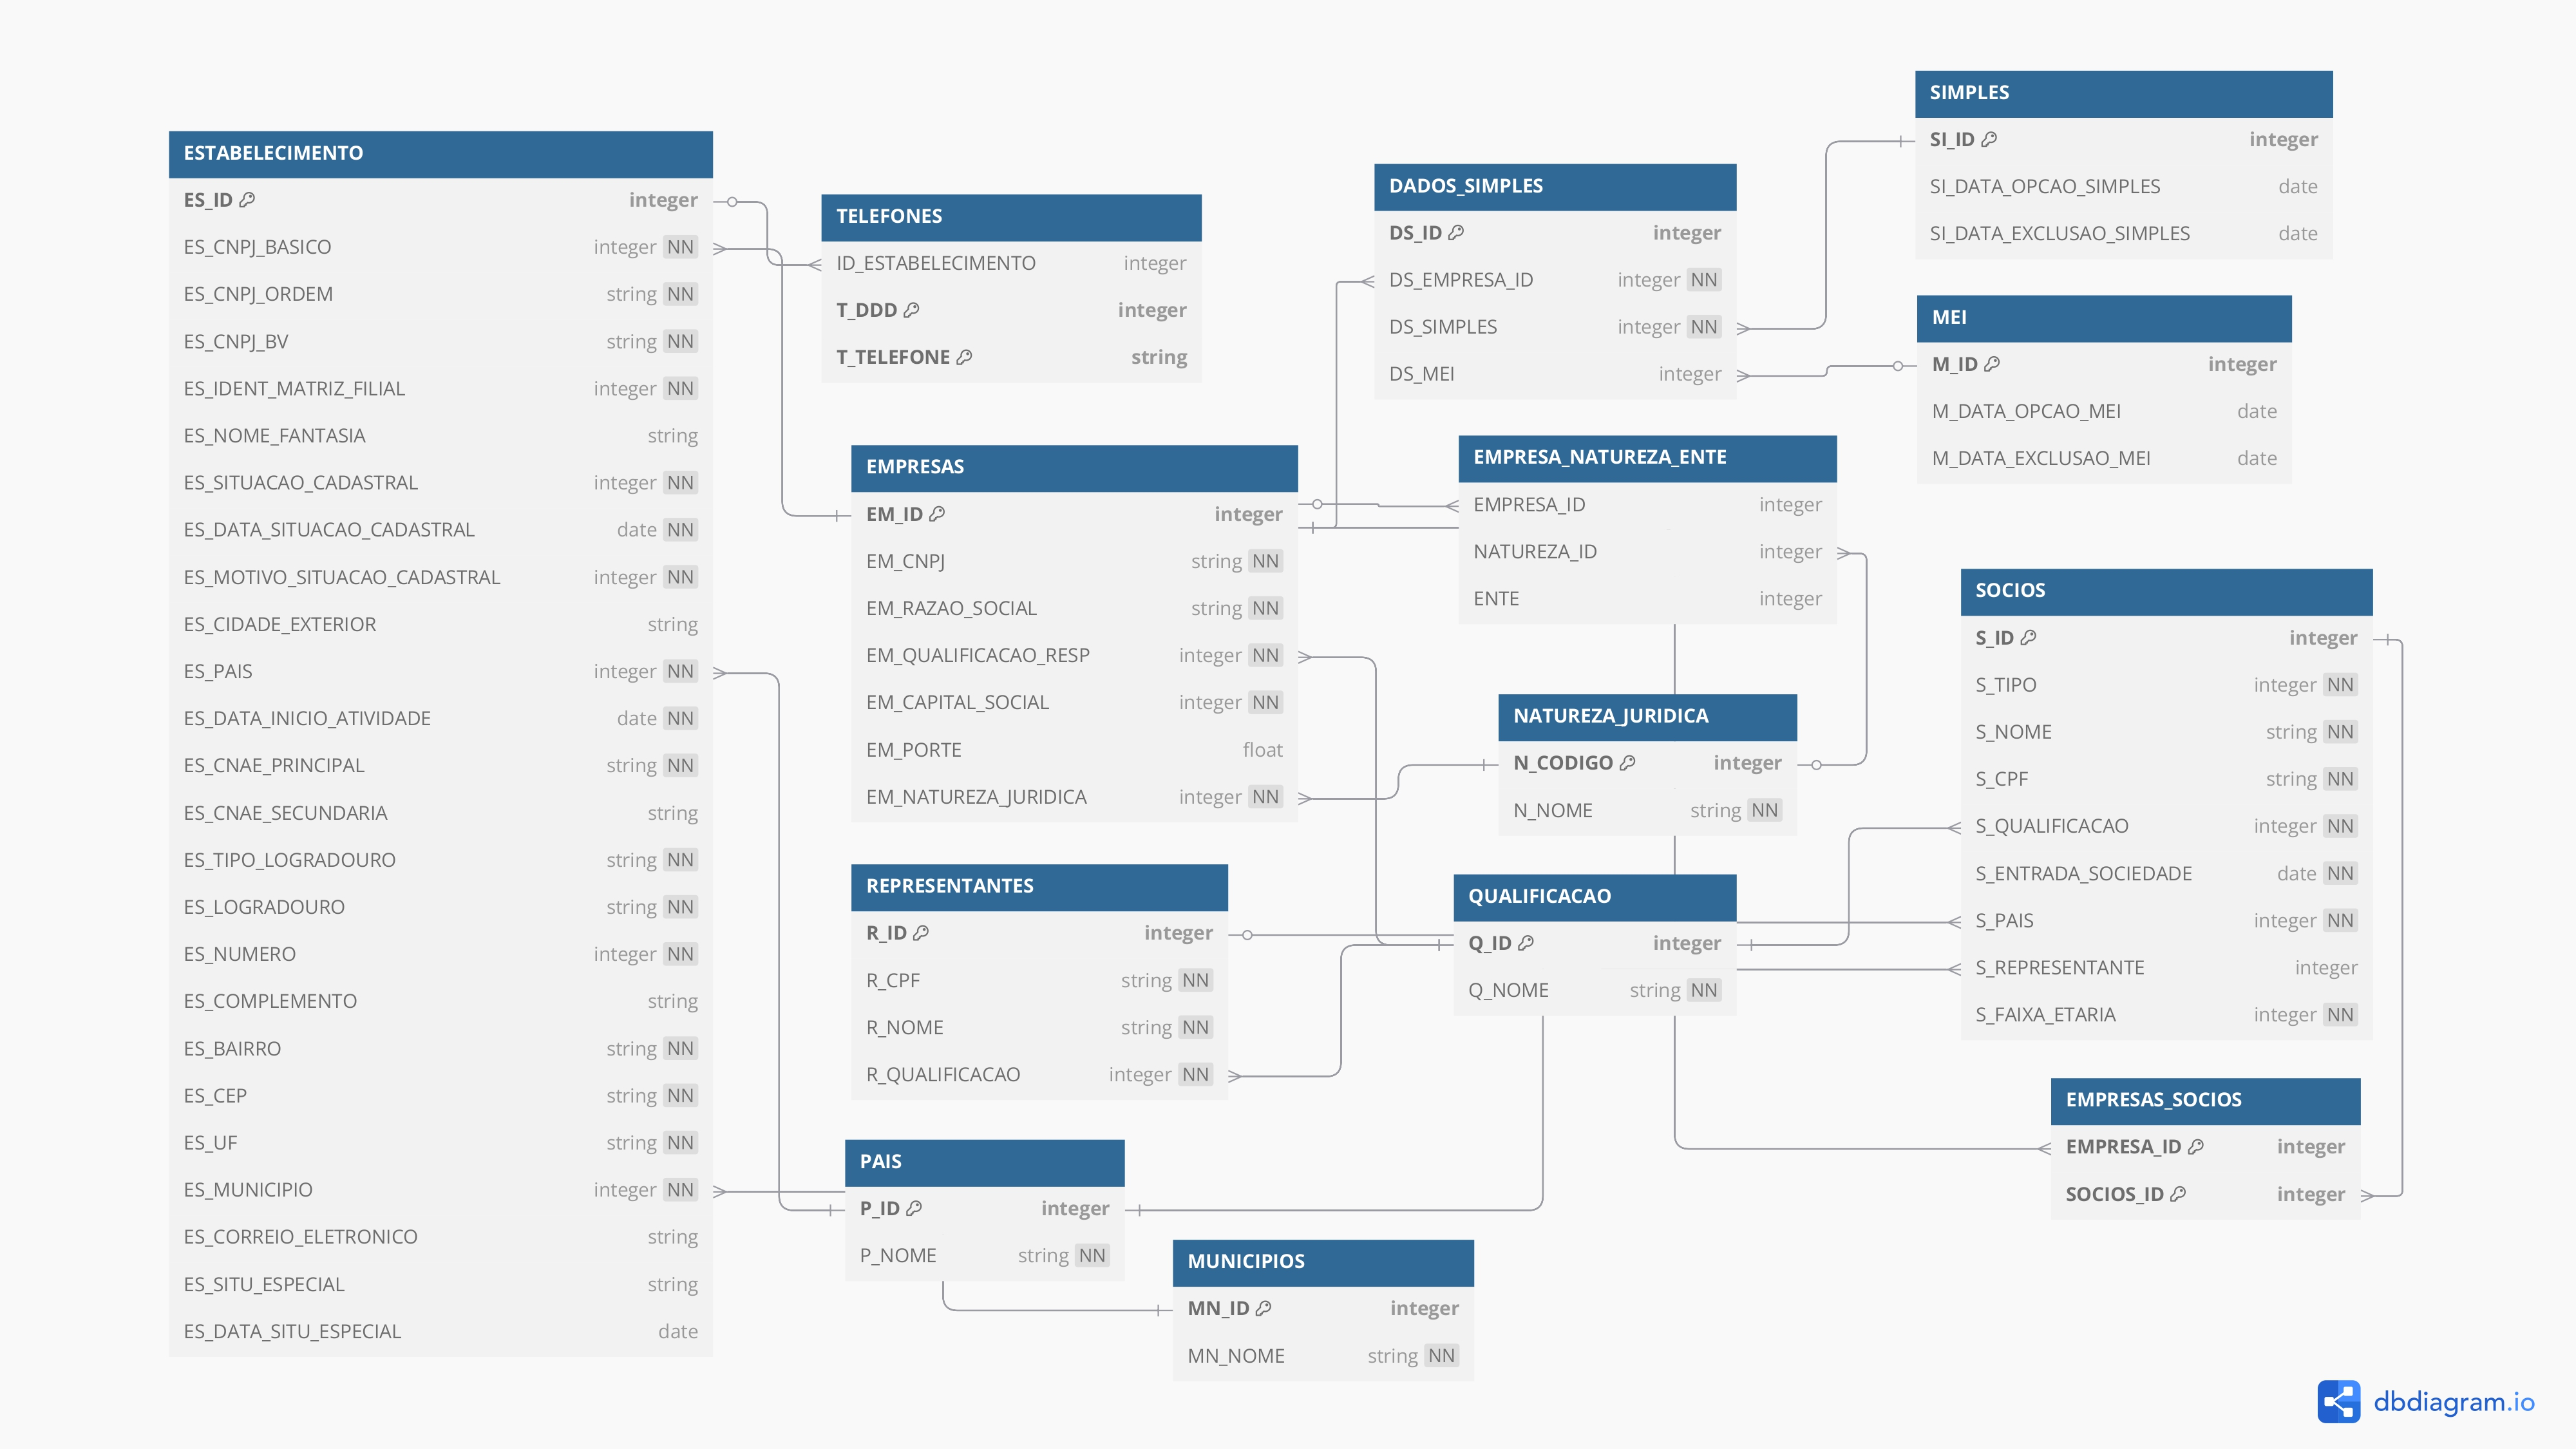

In [30]:
url = 'https://drive.google.com/uc?export=download&id=1DDHJ_EldXpqk_eGcAZYagN_nVQLUC6Or'

response = requests.get(url)
img = BytesIO(response.content)
display(Image(data=img.read(), width=2000))

# 6. Consultas

## 6.1 Duas consultas envolvendo seleção e projeção

### 6.1.1 Seleciona nome e CPF de sócios que se enquadram no tipo "pessoa física"

In [31]:
query = """
SELECT S_NOME, S_CPF
FROM SOCIOS
WHERE S_TIPO == 2
"""

df = pd.read_sql_query(query, conn)
df

,S_NOME,S_CPF
0,EZIEL FRANCISCO GOMES,***587898**
1,LUCIANA MARQUES MOREIRA GOMES,***000458**
2,CARLOS ALBERTO ALVES NOBREGA,***349028**
3,RONALDO AMANCIO,***079148**
4,RAINER WINDSOR DE MOURA ALBERTO,***859428**
...,...,...
973,EXPEDITO ROMEL PEREIRA,***615527**
974,CARLOS RANDOLPHO GROS,***834897**
975,LEONARDO DE SOUSA FREITAS TEIXEIRA,***772617**
976,OTAVIANO OLAVO PIVETTA,***627730**


### 6.1.2 Obtém o CNPJ e a razão social de empresas de grande porte

In [32]:
query = """
SELECT EM_CNPJ, EM_RAZAO_SOCIAL
FROM EMPRESAS
WHERE EM_PORTE = 5;
"""

df = pd.read_sql_query(query, conn)
df

,EM_CNPJ,EM_RAZAO_SOCIAL
0,1319804,GOVEIA & OLIVEIRA LTDA
1,1323728,ANNUNCIATO ADVOGADOS ASSOCIADOS
2,1323750,ESCOLINHA DA BETH EDUCACAO INFANTIL S/C LTDA
3,1324008,A Q M COMERCIO DE SUCATAS LTDA
4,1325438,JACARANDA COMERCIO DE PRODUTOS AGROPECUARIOS LTDA
...,...,...
225,38516928,CAIXA ESCOLAR CRESER-APAE TIMOTEO
226,38522751,SOCIEDADE CURVELANA DE EDUCACAO E CULTURA LTDA
227,38588372,ZIMEX BRASIL REPRESENTACOES COMERCIO IMPORTACA...
228,38712378,REDIL ENGENHARIA ELETRICA COMERCIO E INDUSTRIA...


## 6.2 Três consultas envolvendo junção de duas relações

### 6.2.1 Retorna estabelecimentos que ficam localizados em outros países

In [33]:
#A busca mostra que, em nosso banco, não há estabelecimentos em outros países registrados

query = """
SELECT ES_NOME_FANTASIA, ES_CNPJ_BASICO
FROM ESTABELECIMENTO
JOIN PAIS ON ESTABELECIMENTO.ES_PAIS = PAIS.P_ID
"""

df = pd.read_sql_query(query, conn)
df

,ES_NOME_FANTASIA,ES_CNPJ_BASICO


### 6.2.2 Retorna empresas que contam somente com sócios em uma certa faixa etária

In [34]:
query = """
SELECT E.EM_RAZAO_SOCIAL
FROM EMPRESAS AS E
WHERE EXISTS (
    SELECT 1
    FROM EMPRESAS_SOCIOS AS ES_Inner
    JOIN SOCIOS AS S_Inner ON ES_Inner.SOCIOS_ID = S_Inner.S_ID
    WHERE ES_Inner.EMPRESA_ID = E.EM_ID
      AND S_Inner.S_FAIXA_ETARIA = 4
)
AND NOT EXISTS (
    SELECT 1
    FROM EMPRESAS_SOCIOS AS ES_Outer
    JOIN SOCIOS AS S_Outer ON ES_Outer.SOCIOS_ID = S_Outer.S_ID
    WHERE ES_Outer.EMPRESA_ID = E.EM_ID
      AND S_Outer.S_FAIXA_ETARIA != 4
);
"""

df = pd.read_sql_query(query, conn)
df

,EM_RAZAO_SOCIAL
0,ASSOCIACAO BANDA MUSICAL JUBILO CELESTE
1,"CASEL DE ITABORAI CONSERVACAO, ALIMENTACAO, SE..."
2,ELEICOES 2004 CF - LAGOA DA CONFUSAO - TO - CO...
3,DAUMETAIS INDUSTRIA DE CONFORMACAO LTDA
4,CENTER CARNES JD. SAO MANOEL LTDA
5,DESTILARIA CURVELO LTDA
6,SOCIEDADE ESPORTIVA PARANAIBANA
7,BARTONELLI COMUNICACAO LTDA


### 6.2.3 Retorna nome e origem de sócios estrangeiros

In [35]:
#Especificamos WHERE S.S_PAIS != 0 pois grande parte dos campos estão nulos
query = """
SELECT DISTINCT S.S_NOME, S.S_CPF, P.P_NOME, P.P_ID
FROM SOCIOS AS S
JOIN PAIS AS P
ON S.S_PAIS = P.P_ID
WHERE S.S_PAIS != 0
"""

df = pd.read_sql_query(query, conn)
df

,S_NOME,S_CPF,P_NOME,P_ID
0,RUSSO MANGIMI SPA,10661942000174,ITALIA,386
1,FARMINA PET FOODS HOLDING B.V.,33404466000101,Países Baixos (Holanda),573
2,RUSA - ROHDE & SCHWARZ ANLAGEN GMBH,5730192000105,ALEMANHA,23
3,ROHDE & SCHWARZ GMBH & CO KG,5714979000183,ALEMANHA,23
4,GREINER BIO-ONE GMBH,5624552000194,AUSTRIA,72
5,LYTHEBAS HOLDINGS LTD,20536458000177,"VIRGENS, ILHAS (BRITANICAS)",863


## 6.3 Três consultas envolvendo junção de três ou mais relações

### 6.3.1 Retorna a identificação dos sócios de cada empresa

In [36]:
query = """
SELECT E.EM_RAZAO_SOCIAL AS Razao_Social_Empresa, S.S_NOME AS Nome_Socio, S.S_CPF AS CPF_Socio
FROM EMPRESAS AS E
JOIN EMPRESAS_SOCIOS AS ES
ON E.EM_ID = ES.EMPRESA_ID
JOIN SOCIOS AS S
ON ES.SOCIOS_ID = S.S_ID
ORDER BY E.EM_RAZAO_SOCIAL, S.S_NOME;
"""

df = pd.read_sql_query(query, conn)
df

,Razao_Social_Empresa,Nome_Socio,CPF_Socio
0,A Q M COMERCIO DE SUCATAS LTDA,MARCOS PAULO DE FREITAS,***669168**
1,A Q M COMERCIO DE SUCATAS LTDA,RENATO DE FREITAS,***492588**
2,A. S. L. R. - CONSTRUCOES E SERVICOS LTDA,AGNALDO SANTOS ROSENDO,***250205**
3,A. S. L. R. - CONSTRUCOES E SERVICOS LTDA,ERENITO ROZENDO LIMA,***296985**
4,A.M.B. SERVICOS ELETRICOS S/C LTDA,ANTONIO FRANCISCO DE MACEDO,***919203**
...,...,...,...
854,WORLD PARK REPRESENTACOES LTDA,JEFFERSON PANCOTTI MENDONCA,***669808**
855,WORLD PARK REPRESENTACOES LTDA,KATIA SIMONE SOARES MENDONCA,***966158**
856,WORLD PARK REPRESENTACOES LTDA,VIVIANE PANCOTTI DE MENDONCA BARBADO,***845278**
857,ZIMEX BRASIL REPRESENTACOES COMERCIO IMPORTACA...,JULIA PASSOS MEDEIROS CHAVES,***313456**


### 6.3.2 Quantidade e identificação de estabelecimentos com número de telefone registrado

In [37]:
query = """
SELECT DISTINCT EM.EM_RAZAO_SOCIAL AS Razao_Social_Empresa, E.ES_NOME_FANTASIA AS Nome_Fantasia_Estabelecimento
FROM EMPRESAS AS EM
JOIN ESTABELECIMENTO AS E
ON EM.EM_ID = E.ES_CNPJ_BASICO
JOIN TELEFONES AS T
ON E.ES_ID = T.ID_ESTABELECIMENTO
WHERE T.T_DDD IS NOT NULL AND T.T_TELEFONE IS NOT NULL
ORDER BY EM.EM_RAZAO_SOCIAL, E.ES_NOME_FANTASIA;
"""

df = pd.read_sql_query(query, conn)
df

,Razao_Social_Empresa,Nome_Fantasia_Estabelecimento
0,ABM CONSULTORIA E DESENVOLVIMENTO S/C LTDA,None
1,ACOUGUE DOIS IRMAOS DE QUEIMADOS LTDA,None
2,ADNV SERVICOS ADMINISTRATIVOS LTDA,None
3,ADONAI ESTACIONAMENTO LTDA,ADONAI PARK
4,AGREMIACAO ESPIRITA PARACATUENSE,None
...,...,...
149,W.M.T. TRANSPORTE DE CARGAS LTDA,W M T CARGAS
150,WALFLOR EMPREENDIMENTOS IMOBILIARIOS LTDA,WALFLOR
151,WARM PARTICIPACOES LTDA,WARM PARTICIPACOES
152,WEST PUBLICIDADE LTDA,WEST COMUNICACAO VISUAL


### 6.3.3 Retorna a contagem de estabelecimentos por CNAE principal e Natureza Jurídica

In [38]:
query = """
SELECT E.ES_CNAE_PRINCIPAL AS CNAE_Principal, NJ.N_NOME AS Natureza_Juridica, COUNT(E.ES_ID) AS Total_Estabelecimentos
FROM ESTABELECIMENTO AS E
JOIN EMPRESAS AS EM
ON E.ES_CNPJ_BASICO = EM.EM_ID
JOIN NATUREZA_JURIDICA AS NJ
ON EM.EM_NATUREZA_JURIDICA = NJ.N_CODIGO
GROUP BY E.ES_CNAE_PRINCIPAL, NJ.N_NOME
ORDER BY Total_Estabelecimentos DESC, E.ES_CNAE_PRINCIPAL;
"""

df = pd.read_sql_query(query, conn)
df

,CNAE_Principal,Natureza_Juridica,Total_Estabelecimentos
0,20040802,Associação Privada,24
1,20040803,Sociedade Empresária Limitada,8
2,20040805,Associação Privada,8
3,20040810,Associação Privada,8
4,20011019,Sociedade Empresária Limitada,7
...,...,...,...
312,20190201,Sociedade Empresária Limitada,1
313,20200910,Sociedade Empresária Limitada,1
314,20210924,Sociedade Empresária Limitada,1
315,20220520,Sociedade Empresária Limitada,1


## 6.4 Duas consultas envolvendo agregação sobre junção de duas ou mais relações

### 6.4.1 Número de sócios para cada tipo possível de qualificação presente no BD

In [39]:
query = """
SELECT Q.Q_NOME AS Qualificacao_Socio, COUNT(S.S_ID) AS Total_Socios
FROM SOCIOS AS S
JOIN QUALIFICACAO AS Q
ON S.S_QUALIFICACAO = Q.Q_ID
GROUP BY Q.Q_NOME
ORDER BY Total_Socios DESC;
"""

df = pd.read_sql_query(query, conn)
df

,Qualificacao_Socio,Total_Socios
0,Sócio-Administrador,555
1,Sócio,274
2,Presidente,129
3,Administrador,12
4,Sócio-Gerente,10
5,Sócio Pessoa Jurídica Domiciliado no Exterior,7
6,Diretor,6
7,Titular Pessoa Física Residente ou Domiciliado...,3
8,Sócio Menor (Assistido/Representado),3
9,Sócio com Capital,1


### 6.4.2 Retorna a quantidade de sócios por empresa

In [40]:
query = """
SELECT E.EM_RAZAO_SOCIAL, COUNT(ES.SOCIOS_ID) AS Total_Socios
FROM EMPRESAS AS E
JOIN EMPRESAS_SOCIOS AS ES
ON E.EM_ID = ES.EMPRESA_ID
GROUP BY E.EM_ID, E.EM_RAZAO_SOCIAL
ORDER BY Total_Socios DESC;
"""

df = pd.read_sql_query(query, conn)
df

,EM_RAZAO_SOCIAL,Total_Socios
0,V&F ADMINISTRADORA E CORRETORA DE SEGUROS LTDA,7
1,MASTERSIGN CERTIFICADORA DIGITAL LTDA.,7
2,"GREINER BIO-ONE BRASIL SERVICE TECH SISTEMAS, ...",5
3,THORUS SCISOFT TECNOLOGIA LTDA,5
4,BRASIL COMERCIO E REPRESENTACAO COMERCIAL DE A...,4
...,...,...
478,CAIXA ESCOLAR CRESER-APAE TIMOTEO,1
479,SOCIEDADE CURVELANA DE EDUCACAO E CULTURA LTDA,1
480,SERRARIA CARDOSO OLHOS DAGUA LTDA,1
481,OVER NIGHT MODA INTIMA LTDA,1


# 7. Autoavaliação dos membros

Para a realização do presente trabalho, as tarefas foram divididas da seguinte forma:

**Izabela:** Durante a divisão de tarefas do trabaho prático 2 da disciplina, fiquei encarregada, principalmente, do tratamento dos dados de entradas e produção do material para apresentação. Também auxiliei minhas colegas nas tarefas delas. No geral, o trabalho foi muito bem dividido e todas colaboraram para o seu desenvolvimento. Quanto às minhas responsabilidades, creio que minha maior dificuldade foi na seleção de instâncias. Apesar disso parecer simples para outros trabalhos, no nosso caso, o dataset possuia muitas tabelas com milhares de instâncias. Tive que desenvolver um script em python para selecionar corretamente as instâncias em todas as tabelas e isso se tornou extremamente trabalhoso e demorado. Através da produção da apresentação, pude também compreender completamente o trabalho como um todo e não só as partes que fui designada, o que colaborou muito para o meu entendimento das habilidades relacionadas à disciplina necessárias para a execução deste.

**Lara:** Durante a realização do trabalho, minhas principais tarefas foram produzir a normalização das relações iniciais contidas nos dados originais, além de elaborar e implementar as queries a serem realizadas sobre o Banco de Dados já normalizado e devidamente construído. Dessa forma, pude exercitar, em especial, aspectos mais teóricos da disciplina (como álgebra relacional e o processo de normalização em si), além de interagir com SQL. Os principais desafios enfrentados foram a compreensão e interpretação dos dados originais fornecidos e a identificação de possíveis inconsistências nos dados originais ao realizar consultas sobre o Banco (como, por exemplo, a ausência frequente de determinados campos, como o país a que sócios ou estabelecimentos estão associados).

**Márcia:**
Suas principais responsabilidades foram a importação dos dados para o notebook, a normalização do banco de dados (seção 3 do presente trabalho), e a criação dos esquemas ER e Relacional. Dessa forma, a integrante lidou com diversos desafios técnicos do trabalho, exercitando diversas habilidades de programação, desde a importação dos dados dos arquivos csv até a definição de um novo esquema na linguagem SQL. Ademais, a integrante também exercitou conceitos de modelagem de bancos de dados, ao criar os esquemas ER e relacional do banco de dados após a normalização. Os principais desafios enfrentados foram em relação à migração dos dados dos esquemas não normalizados para o novo esquema, que articulou simultaneamente os conceitos e a prática das consultas SQL.
